<a href="https://colab.research.google.com/github/tcglarry/something_new/blob/master/TFDS_ARC_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFDS ARC Dataset
This notebook shows how to use the TFDS Dataset for the ARC dataset, located at https://github.com/fchollet/ARC and described in François Chollet's paper [The Measure of Intelligence](https://arxiv.org/pdf/1911.01547.pdf).

Notes about this implementation:
* In the original ARC dataset, grid sizes vary from 1x1 to 30x30. However, the `Example` protobuf format does not support such variation, so I stored all grids as 30x30, filling up with 0, and I added a separate field for the grid size, for each grid. For example:

```
Original ARC grid pair:

{
  "input": [[1,2],[3,4],[5,6]],  # 3x2
  "output": [[1,2,3,4],[5,6,7,8]]  # 2x4
}

TFDS ARC grid pair:

{
  "input": [[1,2,0,0,...,0],[3,4,0,0,...,0],[5,6,0,0,...,0], [0,0,...,0], ..., [0,0,...,0]],  # 30x30
  "input_size": [3,2],
  "output": [[1,2,3,4,0,0,...,0],[5,6,7,7,0,0,...,0],[0,0,...,0], ..., [0,0,...,0]]  # 30x30
  "output_size": [2,4],
}
```

First, we need to install my fork of the TFDS Datasets project. See the [Pull Request #1197](https://github.com/tensorflow/datasets/pull/1197) to get this dataset into the original TFDS Datasets project.

In [0]:
!pip install -q -U https://github.com/ageron/datasets/archive/add_arc.zip

     / 268.5MB 80.4MB/s


Next let's import TensorFlow 2.x, TFDS and matplotlib:

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets.public_api as tfds

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


Now we can load the ARC dataset easily:

In [0]:
arc = tfds.load("arc")

We will need a small function to crop and plot grids using the same colormap as in the [testing interface](https://github.com/fchollet/ARC#usage-of-the-testing-interface).

In [0]:
COLOR_MAP = cm.colors.ListedColormap([
  "#000000", # 0 = black
  "#0074D9", # 1 = blue
  "#FF4136", # 2 = red
  "#2ECC40", # 3 = green
  "#FFDC00", # 4 = yellow
  "#AAAAAA", # 5 = grey
  "#F012BE", # 6 = fuschia
  "#FF851B", # 7 = orange
  "#7FDBFF", # 8 = teal
  "#870C25", # 9 = brown
])

def crop_and_plot_grid(grid, size, title):
  size = size.numpy().tolist()
  grid = grid[:size[0], :size[1]]
  plt.imshow(grid, cmap=COLOR_MAP, vmin=0, vmax=9)
  plt.title(f"{title} ({size[0]}x{size[1]})")

Now let's iterate over the first 3 tasks in the training set. For each task, we will display the demonstration pairs and the test pairs (each pair consists of an input grid and an output grid).

________________________________________________________________________________
Task training/7df24a62
  Subset: train


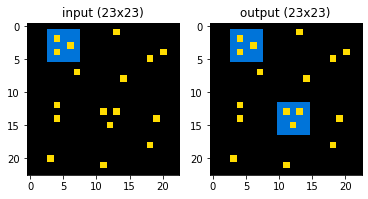

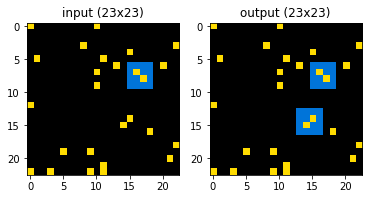

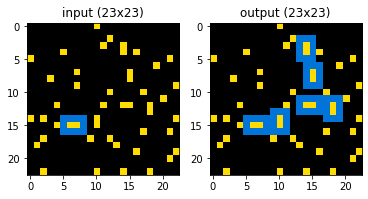

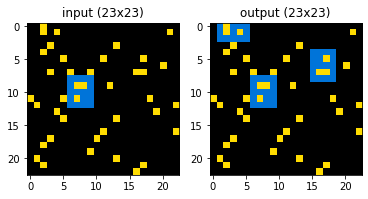

  Subset: test


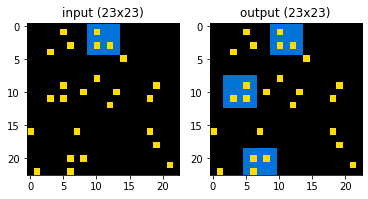

________________________________________________________________________________
Task training/91714a58
  Subset: train


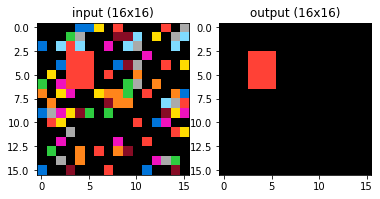

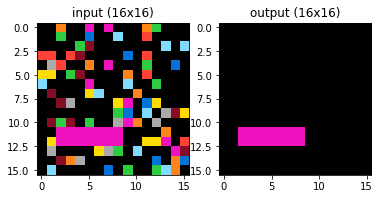

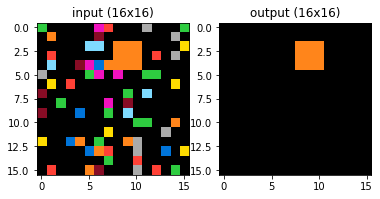

  Subset: test


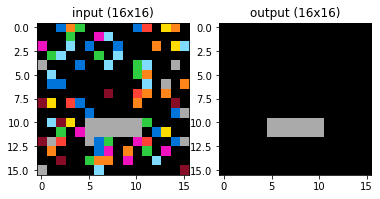

________________________________________________________________________________
Task training/77fdfe62
  Subset: train


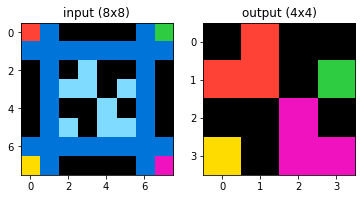

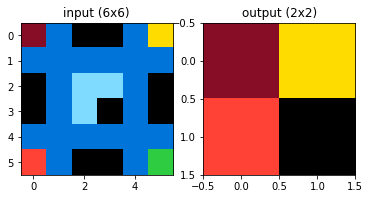

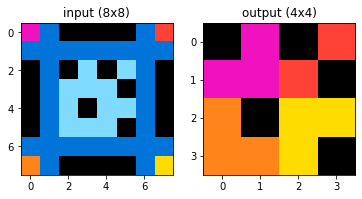

  Subset: test


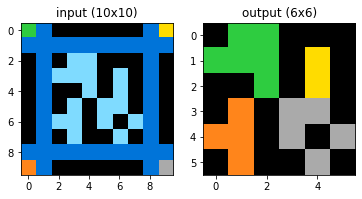

In [0]:
for task in arc["train"].take(3):
  print("_" * 80)
  task_id = task["task_id"].numpy().decode("utf-8")
  print(f"Task training/{task_id}")
  for subset in ("train", "test"):
    print("  Subset:", subset)
    fields = [list(task[subset][field]) for field in (
        "input", "input_size", "output", "output_size")]
    for input_grid, input_size, output_grid, output_size in zip(*fields):
      plt.subplot(121)
      crop_and_plot_grid(input_grid, input_size, "input")
      plt.subplot(122)
      crop_and_plot_grid(output_grid, output_size, "output")
      plt.show()
    

Now try building an AI that can reach human level on this dataset. The goal is to build a system that can learn to predict the output grids in all test pairs given all the other grids (both the input and output grids in the demonstration pairs and the input grids in the test pairs). The system must eventually be capable of solving the tasks in the evaluation set, which are all different from the ones in the training set. Good luck with that! :)